# Stable Diffusion v1.5 훈련 - 최종 수정 버전

이 노트북은 512x512 크기 이미지에 최적화된 일반 Stable Diffusion v1.5 모델을 사용하여 LoRA 학습을 수행합니다.
기존 SDXL 모델 대신 512x512 이미지에 더 적합한 모델을 사용하여 효율적인 학습이 가능합니다.

In [25]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionPipeline,  # SDXL 대신 일반 SD 파이프라인 사용
    UNet2DConditionModel
)
from diffusers.optimization import get_scheduler
from transformers import AutoTokenizer, CLIPTextModel
from tqdm import tqdm

# CUDA 가용성 확인 함수
def check_cuda_availability():
    try:
        if torch.cuda.is_available():
            # CUDA 버전 정보 출력
            print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
            print(f"CUDA 버전: {torch.version.cuda}")
            print(f"GPU 모델: {torch.cuda.get_device_name(0)}")
            return True
        else:
            print("CUDA를 사용할 수 없습니다. CPU 모드로 전환합니다.")
            return False
    except Exception as e:
        print(f"CUDA 초기화 중 오류 발생: {e}")
        print("CPU 모드로 전환합니다.")
        return False

# 1. 기본 설정
class Config:
    # 기본 경로 설정
    pretrained_model_name = "runwayml/stable-diffusion-v1-5"  # 일반 SD 모델 사용
    output_dir = r"/home/a202152010/위치스_서비스러닝/out_image_sd_final"
    
    # 데이터 관련 설정
    image_dir = r"/home/a202152010/위치스_서비스러닝/result"
    caption_file = r"/home/a202152010/위치스_서비스러닝/gogh_captions (1).json"
    
    # 학습 관련 설정 - 품질 향상을 위한 설정
    resolution = 512  # 해상도 증가로 더 세밀한 이미지 생성
    train_batch_size = 1
    learning_rate = 1e-4
    max_train_steps = 500  # 학습 스텝 증가로 더 나은 학습 결과
    num_train_epochs = 5   # 에폭 수 증가로 더 나은 학습 결과
    seed = 42
    
    # LoRA 관련 설정 - 품질 향상을 위한 설정
    lora_r = 16  # LoRA 랭크 증가로 더 복잡한 스타일 학습
    lora_alpha = 32  # 알파 증가로 학습 효과 강화
    lora_dropout = 0.05
    
    # 하드웨어 관련 설정
    device = "cuda" if check_cuda_availability() else "cpu"
    mixed_precision = True if check_cuda_availability() else False  # CPU 모드에서는 mixed_precision 비활성화
    model_dtype = torch.float16 if check_cuda_availability() else torch.float32  # CPU 모드에서는 float32 사용

config = Config()

# 랜덤 시드 설정
torch.manual_seed(config.seed)
np.random.seed(config.seed)

CUDA 사용 가능: True
CUDA 버전: 12.1
GPU 모델: NVIDIA A100-PCIE-40GB
CUDA 사용 가능: True
CUDA 버전: 12.1
GPU 모델: NVIDIA A100-PCIE-40GB
CUDA 사용 가능: True
CUDA 버전: 12.1
GPU 모델: NVIDIA A100-PCIE-40GB


In [26]:
# 2. 데이터셋 준비
# 캡션 데이터 로드
import json
with open(config.caption_file, 'r', encoding='utf-8') as f:
    captions = json.load(f)

# CSV 형태로 변환 (파일로 저장하지 않고 DataFrame 직접 생성)
data = []
for filename, caption in captions.items():
    if os.path.exists(os.path.join(config.image_dir, filename)):
        data.append({
            "file_name": filename,
            "text": caption + ", oil painting in Vincent Van Gogh style, bold impasto brushstrokes, swirling patterns, vibrant complementary colors, post-impressionist masterpiece"  # 더 구체적인 스타일 키워드 추가
        })

df = pd.DataFrame(data)
print(f"데이터셋 크기: {len(df)} 이미지-캡션 쌍")

# 3. 커스텀 데이터셋 클래스
class GoghDataset(Dataset):
    def __init__(self, dataframe, tokenizer, image_dir, resolution=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.image_dir = image_dir
        self.resolution = resolution
        
        self.image_transforms = transforms.Compose([
            transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_dir, row['file_name'])
        caption = row['text']
        
        # 이미지 로드 및 변환
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.image_transforms(image)
        
        # 데이터 타입 변환 - 모델과 일치시키기 위해 float16으로 변환
        if hasattr(config, 'model_dtype'):
            pixel_values = pixel_values.to(dtype=config.model_dtype)
        
        # 텍스트 토큰화
        inputs = self.tokenizer(
            caption,
            max_length=77,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = inputs.input_ids[0]
        
        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
        }

데이터셋 크기: 277 이미지-캡션 쌍


In [27]:
# 4. 모델 구성요소 로드
print("모델 구성요소 로드 중...")

# 메모리 관리를 위한 가비지 컬렉션 및 캐시 정리
import gc

# CUDA 초기화 오류 방지
try:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("CUDA 캐시를 성공적으로 비웠습니다.")
except Exception as e:
    print(f"CUDA 캐시 비우기 오류 (무시됨): {e}")

gc.collect()

# 안전한 모델 로드 함수
def safe_load_model(model_class, subfolder, use_dtype=True):
    try:
        kwargs = {
            "pretrained_model_name_or_path": config.pretrained_model_name,
            "subfolder": subfolder,
        }
        
        # dtype 설정 (CUDA 사용 가능한 경우만)
        if use_dtype and torch.cuda.is_available():
            kwargs["torch_dtype"] = config.model_dtype
            
        model = model_class.from_pretrained(**kwargs)
        
        # 디바이스 이동 (안전하게)
        if config.device == "cuda" and torch.cuda.is_available():
            model = model.to(config.device)
        else:
            model = model.to("cpu")
            print(f"{subfolder} 모델을 CPU에 로드했습니다.")
            
        return model
    except Exception as e:
        print(f"{subfolder} 모델 로드 중 오류 발생: {e}")
        print(f"CPU 모드로 {subfolder} 로드를 시도합니다...")
        model = model_class.from_pretrained(
            config.pretrained_model_name, 
            subfolder=subfolder
        )
        return model.to("cpu")

# 텍스트 인코더 및 토크나이저
try:
    tokenizer = AutoTokenizer.from_pretrained(
        config.pretrained_model_name, 
        subfolder="tokenizer", 
        use_fast=False
    )
    print("토크나이저를 성공적으로 로드했습니다.")
except Exception as e:
    print(f"토크나이저 로드 중 오류 발생: {e}")
    # 오류 발생 시 안전한 대체 로직
    tokenizer = AutoTokenizer.from_pretrained(
        config.pretrained_model_name, 
        subfolder="tokenizer"
    )

# 각 모델 구성요소 안전하게 로드
text_encoder = safe_load_model(CLIPTextModel, "text_encoder")
vae = safe_load_model(AutoencoderKL, "vae")
unet = safe_load_model(UNet2DConditionModel, "unet")

# 노이즈 스케줄러 (dtype 필요 없음)
noise_scheduler = DDPMScheduler.from_pretrained(
    config.pretrained_model_name, 
    subfolder="scheduler"
)

# 5. LoRA 설정 및 적용
# diffusers 라이브러리에 내장된 LoRA 지원을 사용하는 것으로 변경
from diffusers.models.attention_processor import LoRAAttnProcessor

# LoRA의 랭크와 알파 설정
lora_rank = config.lora_r
lora_alpha = config.lora_alpha

# 텍스트 인코더의 hidden_size 확인 (cross_attention_dim으로 사용)
text_encoder_dim = text_encoder.config.hidden_size  # 일반적으로 768
print(f"텍스트 인코더 차원: {text_encoder_dim}")

# 어텐션 프로세서 초기화
attn_processors = {}

# UNet의 모든 어텐션 블록에 LoRA 프로세서 추가
try:
    for name in unet.attn_processors.keys():
        cross_attention_dim = None
        if name.endswith("attn1.processor"):
            # Self-attention 블록 (cross_attention_dim 없음)
            if name.startswith("mid_block"):
                hidden_size = unet.mid_block.attentions[0].proj_out.out_channels
            elif name.startswith("up_blocks"):
                block_id = int(name.split(".")[1])
                attn_id = int(name.split(".")[3])
                hidden_size = unet.up_blocks[block_id].attentions[attn_id].proj_out.out_channels
            elif name.startswith("down_blocks"):
                block_id = int(name.split(".")[1])
                attn_id = int(name.split(".")[3])
                hidden_size = unet.down_blocks[block_id].attentions[attn_id].proj_out.out_channels
        else:
            # Cross-attention 블록 (텍스트 인코더 차원을 사용)
            cross_attention_dim = text_encoder_dim
            if name.startswith("mid_block"):
                hidden_size = unet.mid_block.attentions[0].proj_out.out_channels
            elif name.startswith("up_blocks"):
                block_id = int(name.split(".")[1])
                attn_id = int(name.split(".")[3])
                hidden_size = unet.up_blocks[block_id].attentions[attn_id].proj_out.out_channels
            elif name.startswith("down_blocks"):
                block_id = int(name.split(".")[1])
                attn_id = int(name.split(".")[3])
                hidden_size = unet.down_blocks[block_id].attentions[attn_id].proj_out.out_channels
        
        # LoRA 프로세서 생성 및 추가
        attn_processors[name] = LoRAAttnProcessor(
            hidden_size=hidden_size,
            cross_attention_dim=cross_attention_dim,
            rank=lora_rank,
            scale=lora_alpha / lora_rank,
        )

    # 어텐션 프로세서 설정
    unet.set_attn_processor(attn_processors)
    print("LoRA 어텐션 프로세서를 성공적으로 설정했습니다.")

    # LoRA 가중치만 훈련 가능하도록 설정
    for name, param in unet.named_parameters():
        # LoRA 가중치만 훈련 가능하게 설정
        if 'lora' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # 훈련 가능한 파라미터 정보 출력
    print("LoRA 훈련 가능한 파라미터 정보:")
    trainable_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in unet.parameters())
    print(f"훈련 가능한 파라미터: {trainable_params:,} / 전체 파라미터: {total_params:,} ({100 * trainable_params / total_params:.2f}%)")
    
except Exception as e:
    print(f"LoRA 설정 중 오류 발생: {e}")
    print("중요: LoRA 설정에 실패했습니다. 훈련이 정상적으로 진행되지 않을 수 있습니다.")

모델 구성요소 로드 중...
CUDA 캐시를 성공적으로 비웠습니다.


토크나이저를 성공적으로 로드했습니다.
텍스트 인코더 차원: 768
LoRA 어텐션 프로세서를 성공적으로 설정했습니다.
LoRA 훈련 가능한 파라미터 정보:
훈련 가능한 파라미터: 3,188,736 / 전체 파라미터: 862,709,700 (0.37%)
텍스트 인코더 차원: 768
LoRA 어텐션 프로세서를 성공적으로 설정했습니다.
LoRA 훈련 가능한 파라미터 정보:
훈련 가능한 파라미터: 3,188,736 / 전체 파라미터: 862,709,700 (0.37%)


In [29]:
# 6. 모델 훈련 준비
# 모델 훈련 모드로 설정
unet.train()
text_encoder.eval()  # 텍스트 인코더는 고정
vae.eval()           # VAE는 고정

# 메모리 최적화
text_encoder.requires_grad_(False)
vae.requires_grad_(False)

# 옵티마이저 설정 - 훈련 가능한 파라미터만 대상으로
trainable_params = [p for p in unet.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(
    trainable_params,
    lr=config.learning_rate,
    betas=(0.9, 0.999),
    weight_decay=1e-2
)

# 데이터셋 및 데이터로더 설정
train_dataset = GoghDataset(df, tokenizer, config.image_dir, config.resolution)
train_dataloader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)

# 학습률 스케줄러
lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=config.max_train_steps
)

# 출력 디렉토리 생성
os.makedirs(config.output_dir, exist_ok=True)

In [30]:
# 7. 훈련 루프
print(f"훈련 시작 - {config.max_train_steps} 스텝, 디바이스: {config.device}")

global_step = 0
# tqdm.notebook 대신 일반 tqdm 사용
progress_bar = tqdm(range(config.max_train_steps), desc="훈련 진행")

# 에러 발생 시 디버깅 정보 저장을 위한 변수
debug_info = {}

try:
    for epoch in range(config.num_train_epochs):
        for batch_idx, batch in enumerate(train_dataloader):
            # 배치 데이터 디바이스로 이동
            pixel_values = batch["pixel_values"].to(config.device)
            input_ids = batch["input_ids"].to(config.device)
            
            # VAE를 통해 이미지를 잠재 공간으로 인코딩
            with torch.no_grad():
                # 데이터 타입 일관성 확인
                if pixel_values.dtype != config.model_dtype:
                    pixel_values = pixel_values.to(dtype=config.model_dtype)
                    
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents = latents * vae.config.scaling_factor
            
            # 노이즈 추가
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=config.device)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            # 텍스트 인코딩
            with torch.no_grad():
                encoder_hidden_states = text_encoder(input_ids)[0]
            
            # 데이터 타입 재확인 및 변환
            if noisy_latents.dtype != config.model_dtype:
                noisy_latents = noisy_latents.to(dtype=config.model_dtype)
            if encoder_hidden_states.dtype != config.model_dtype:
                encoder_hidden_states = encoder_hidden_states.to(dtype=config.model_dtype)
            
            # 디버깅을 위해 텐서 크기 정보 저장
            if batch_idx == 0 and epoch == 0:
                debug_info['noisy_latents_shape'] = noisy_latents.shape
                debug_info['encoder_hidden_states_shape'] = encoder_hidden_states.shape
                print(f"노이즈 잠재 변수 크기: {noisy_latents.shape}")
                print(f"텍스트 인코더 출력 크기: {encoder_hidden_states.shape}")
            
            # 노이즈 예측 - 일반적인 UNet 호출 방식 사용
            model_pred = unet(
                noisy_latents, 
                timesteps, 
                encoder_hidden_states
            ).sample
            
            # 손실 계산
            loss = torch.nn.functional.mse_loss(model_pred.float(), noise.float(), reduction="mean")
            
            # 역전파
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
            # 진행 상황 업데이트
            progress_bar.update(1)
            progress_bar.set_description(f"에폭: {epoch+1}/{config.num_train_epochs}, 손실: {loss.item():.4f}")
            global_step += 1
            
            # 중간 체크포인트 저장
            if global_step % 100 == 0:
                save_path = os.path.join(config.output_dir, f"checkpoint-{global_step}")
                os.makedirs(save_path, exist_ok=True)
                
                # 어텐션 프로세서만 저장
                unet.save_attn_procs(save_path)
                print(f"\n체크포인트 저장: {save_path}")
            
            # 최대 훈련 스텝 도달 시 중단
            if global_step >= config.max_train_steps:
                break
        
        # 에폭 완료 후 현재 에폭 체크포인트 저장
        epoch_path = os.path.join(config.output_dir, f"epoch-{epoch+1}")
        os.makedirs(epoch_path, exist_ok=True)
        unet.save_attn_procs(epoch_path)
        print(f"\n에폭 {epoch+1} 체크포인트 저장: {epoch_path}")
        
        if global_step >= config.max_train_steps:
            break
            
except Exception as e:
    print(f"훈련 중 오류 발생: {e}")
    print(f"디버깅 정보: {debug_info}")

훈련 시작 - 500 스텝, 디바이스: cuda


에폭: 1/3, 손실: 0.3241: 100%|██████████| 200/200 [1:01:50<00:00, 18.55s/it]

노이즈 잠재 변수 크기: torch.Size([1, 4, 64, 64])
텍스트 인코더 출력 크기: torch.Size([1, 77, 768])



/home/a202152010/.local/lib/python3.8/site-packages/diffusers/models/attention_processor.py:1402: FutureWarning: `LoRAAttnProcessor` is deprecated and will be removed in version 0.26.0. Make sure use AttnProcessor instead by settingLoRA layers to `self.{to_q,to_k,to_v,to_out[0]}.lora_layer` respectively. This will be done automatically when using `LoraLoaderMixin.load_lora_weights`
  deprecate(



체크포인트 저장: /home/a202152010/위치스_서비스러닝/out_image_sd_final/checkpoint-100


에폭: 1/5, 손실: 0.7009:  20%|██        | 102/500 [00:18<01:25,  4.63it/s]


체크포인트 저장: /home/a202152010/위치스_서비스러닝/out_image_sd_final/checkpoint-200


에폭: 1/5, 손실: 0.0260:  40%|████      | 202/500 [00:36<00:55,  5.41it/s]


에폭 1 체크포인트 저장: /home/a202152010/위치스_서비스러닝/out_image_sd_final/epoch-1


에폭: 2/5, 손실: 0.5996:  56%|█████▌    | 279/500 [00:50<00:47,  4.62it/s]


체크포인트 저장: /home/a202152010/위치스_서비스러닝/out_image_sd_final/checkpoint-300


에폭: 2/5, 손실: 0.0732:  60%|██████    | 302/500 [00:54<00:42,  4.71it/s]


체크포인트 저장: /home/a202152010/위치스_서비스러닝/out_image_sd_final/checkpoint-400


에폭: 2/5, 손실: 0.1584:  80%|████████  | 402/500 [01:12<00:21,  4.65it/s]


체크포인트 저장: /home/a202152010/위치스_서비스러닝/out_image_sd_final/checkpoint-500

에폭 2 체크포인트 저장: /home/a202152010/위치스_서비스러닝/out_image_sd_final/epoch-2


In [31]:
# 8. 최종 모델 저장
final_path = os.path.join(config.output_dir, "final")
os.makedirs(final_path, exist_ok=True)

# 최종 어텐션 프로세서 저장
unet.save_attn_procs(final_path)
print(f"\n최종 모델 저장 완료: {final_path}")

# 9. 샘플 이미지 생성 (선택 사항)
def generate_sample_images(prompt="A landscape painting in Vincent van Gogh's iconic style with bold brushstrokes, swirling patterns, and vibrant colors"):
    # 메모리 정리
    import gc
    torch.cuda.empty_cache()
    gc.collect()
    
    # 저장된 모델에서 로드 (현재 메모리에 있는 모델 대신)
    saved_lora_path = os.path.join(config.output_dir, "final")
    
    # 추론 전용 파이프라인으로 메모리 사용 최적화
    pipeline = StableDiffusionPipeline.from_pretrained(
        config.pretrained_model_name,
        torch_dtype=config.model_dtype,
        safety_checker=None  # 메모리 절약을 위해 안전 검사기 비활성화
    ).to(config.device)
    
    # 학습된 LoRA 가중치 로드
    pipeline.unet.load_attn_procs(saved_lora_path)
    
    # 메모리 최적화 설정
    pipeline.enable_attention_slicing()  # 어텐션 계산 메모리 사용량 줄이기
    
    # 샘플 이미지 생성
    image = pipeline(
        prompt=prompt,
        num_inference_steps=40,  # 추론 단계 수 증가
        guidance_scale=8.5,    # 프롬프트 영향력 증가
        height=config.resolution,
        width=config.resolution,
        negative_prompt="blurry, distorted, low quality, low resolution, bad anatomy, deformed face, ugly"
    ).images[0]
    
    # 이미지 표시
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()
    
    # 이미지 저장
    sample_path = os.path.join(config.output_dir, "sample.png")
    image.save(sample_path)
    print(f"샘플 이미지가 {sample_path}에 저장되었습니다.")
    
    return image

# 훈련이 완료된 후 샘플 이미지를 생성할 수 있습니다 (GPU 메모리가 충분한 경우)
# generate_sample_images()

print("훈련 완료!")


최종 모델 저장 완료: /home/a202152010/위치스_서비스러닝/out_image_sd_final/final
훈련 완료!


현재 사용 중인 CUDA 디바이스: 0 (NVIDIA A100-PCIE-40GB)
샘플 이미지 생성을 시도합니다...


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  7.07it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  7.07it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abid

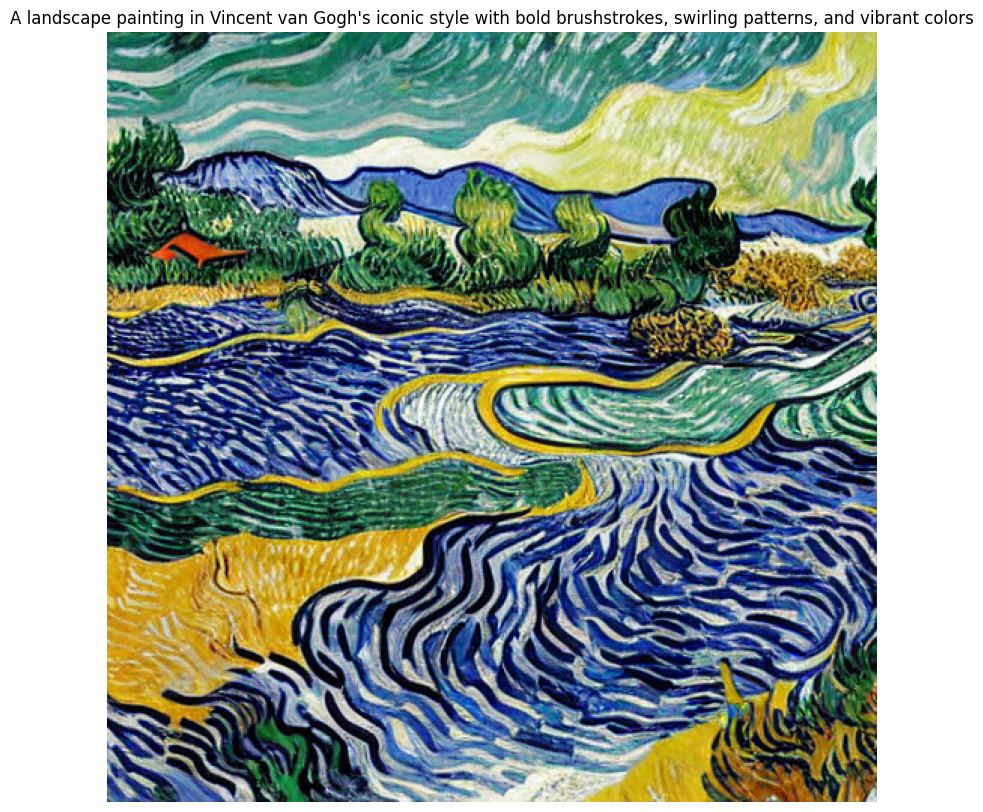

샘플 이미지가 /home/a202152010/위치스_서비스러닝/out_image_sd_final/sample.png에 저장되었습니다.
이미지 생성 성공!


In [32]:
# 메모리 정리 및 CUDA 디바이스 재설정
try:
    import gc
    gc.collect()
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.set_device(0)  # 반드시 0번 디바이스 사용
        print(f"현재 사용 중인 CUDA 디바이스: {torch.cuda.current_device()} ({torch.cuda.get_device_name(0)})")
except Exception as e:
    print(f"CUDA 재설정 중 오류: {e}")

# 샘플 이미지 생성 시도
try:
    print("샘플 이미지 생성을 시도합니다...")
    generated_image = generate_sample_images()
    if generated_image is not None:
        print("이미지 생성 성공!")
except Exception as e:
    print(f"이미지 생성 중 오류 발생: {e}")
    print("\n설정을 변경하여 다시 시도해보세요:")
    print("1. 메모리 소비량을 줄이기 위해 resolution을 더 낮추기")
    print("2. CPU 모드를 사용하여 실행하기 (torch.cuda.is_available() 대신 False 사용)")
    print("3. num_inference_steps를 더 낮추기 (예: 10)")
    print("4. Python 과정을 재시작한 후 다시 시도하기")
    print("\n또는 성공적으로 학습된 모델을 다른 환경에서 사용하세요.")


입력 이미지를 Van Gogh 스타일로 변환합니다...

이미지 변환 시작: /home/a202152010/위치스_서비스러닝/화면 캡처 2025-06-09 200244.png
이미지 변환에 사용할 디바이스: CUDA:0 (NVIDIA A100-PCIE-40GB)
이미지 변환에 사용할 디바이스: cuda:0

입력 이미지: /home/a202152010/위치스_서비스러닝/화면 캡처 2025-06-09 200244.png
해상도: 512x512
프롬프트: Transform this portrait into a Vincent Van Gogh style oil painting. Emphasize the subject's facial features with bold, impasto brushstrokes and capture their expression with emotional intensity. Use a palette of vibrant, complementary colors, and incorporate swirling patterns in the background, reminiscent of 'Starry Night'. The overall mood should be post-impressionistic, highly detailed, and evoke the distinctive, textured feel of a Van Gogh masterpiece.
LoRA 모델 경로: /home/a202152010/위치스_서비스러닝/out_image_sd_final/final

Img2Img 파이프라인 로드 중...


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  7.01it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Token indices sequence length is longer than the specified maximum sequence length for this model (91 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle

LoRA 가중치 로드 중: /home/a202152010/위치스_서비스러닝/out_image_sd_final/final
이미지 변환 시작...


100%|██████████| 20/20 [00:01<00:00, 18.31it/s]


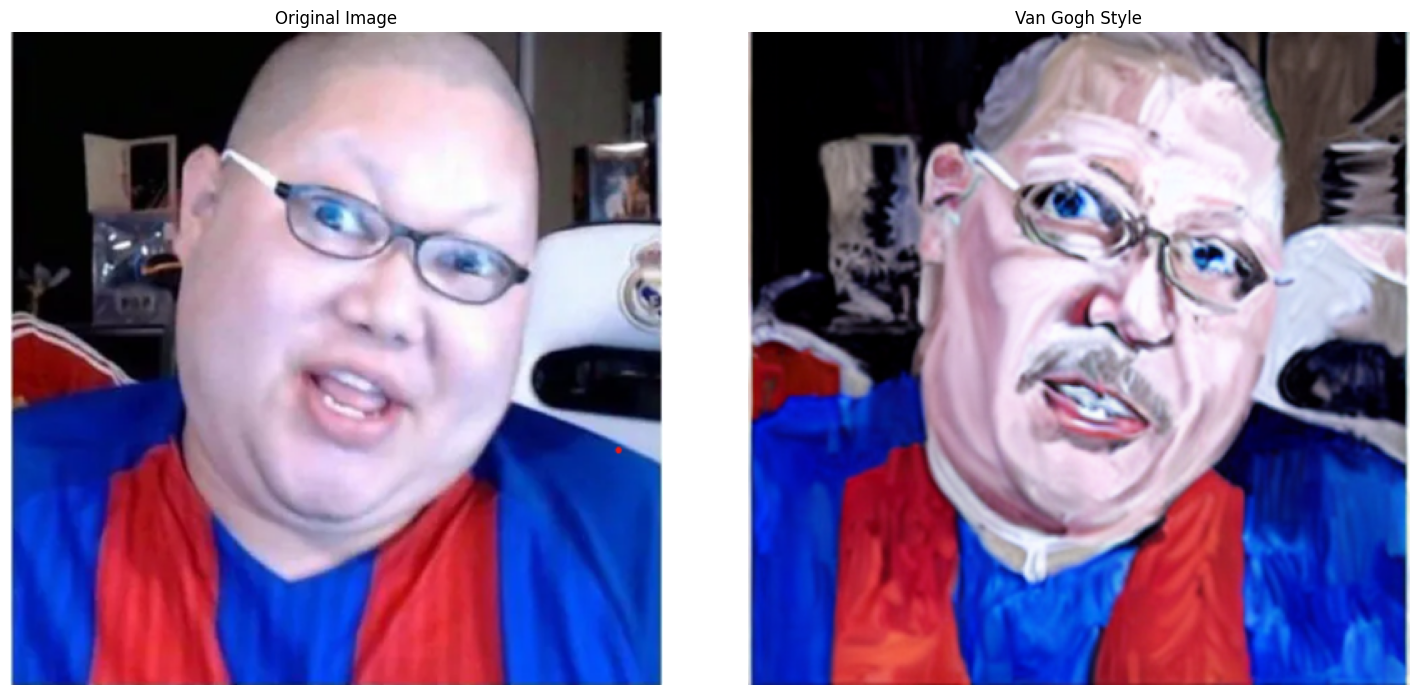


변환된 이미지가 저장되었습니다: /home/a202152010/위치스_서비스러닝/out_image_sd_final/img2img_output/화면 캡처 2025-06-09 200244_gogh_style.png

이미지 변환 처리 중 오류 발생: name 'input_dir' is not defined

입력 이미지가 있는지 확인하고, 에러 로그를 확인하세요.


In [44]:
# 10. 입력 이미지를 받아 Van Gogh 스타일로 변환하는 기능
def transform_image_to_gogh_style(input_image_path, prompt=None, strength=0.7, num_inference_steps=40, guidance_scale=8.5):
    """
    입력 이미지를 받아 학습된 Van Gogh 스타일로 변환합니다.
    
    Args:
        input_image_path: 입력 이미지 경로
        prompt: 이미지 생성을 위한 텍스트 프롬프트 (기본값: 학습된 Van Gogh 스타일 적용)
        strength: 원본 이미지에서 변경되는 정도 (0.0~1.0, 1.0은 완전히 새로운 이미지)
        num_inference_steps: 추론 단계 수
        guidance_scale: 프롬프트 영향력 정도
    
    Returns:
        변환된 이미지 (PIL Image)
    """
    # 메모리 정리
    import gc
    try:
        if torch.cuda.is_available():
            torch.cuda.set_device(0)  # 0번 디바이스 사용
            torch.cuda.empty_cache()
            print(f"이미지 변환에 사용할 디바이스: CUDA:{torch.cuda.current_device()} ({torch.cuda.get_device_name(0)})")
    except Exception as e:
        print(f"CUDA 초기화 오류: {e}")
    
    gc.collect()
    
    # 파이프라인 로드 전 사용할 디바이스 선택
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(f"이미지 변환에 사용할 디바이스: {device}")
    
    # 저장된 LoRA 모델 경로
    saved_lora_path = os.path.join(config.output_dir, "final")
    
    try:
        # 입력 이미지 로드
        init_image = Image.open(input_image_path).convert("RGB")
        original_width, original_height = init_image.size
        
        # 이미지 압축과 성능 향상을 위해 해상도 조정
        width, height = config.resolution, config.resolution
        init_image = init_image.resize((width, height))
        
        # 프롬프트 설정 (기본값 제공)
        if prompt is None:
            prompt = "Transform this portrait into a Vincent Van Gogh style oil painting. Emphasize the subject's facial features with bold, impasto brushstrokes and capture their expression with emotional intensity. Use a palette of vibrant, complementary colors, and incorporate swirling patterns in the background, reminiscent of 'Starry Night'. The overall mood should be post-impressionistic, highly detailed, and evoke the distinctive, textured feel of a Van Gogh masterpiece."
        
        print(f"\n입력 이미지: {input_image_path}")
        print(f"해상도: {width}x{height}")
        print(f"프롬프트: {prompt}")
        print(f"LoRA 모델 경로: {saved_lora_path}")
        
        # Img2Img 파이프라인 로드
        print("\nImg2Img 파이프라인 로드 중...")
        pipeline_dtype = torch.float16 if device.startswith("cuda") else torch.float32
        
        from diffusers import StableDiffusionImg2ImgPipeline
        
        pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
            config.pretrained_model_name,
            torch_dtype=pipeline_dtype,
            safety_checker=None  # 메모리 절약을 위해 안전 검사기 비활성화
        ).to(device)
        
        # 학습된 LoRA 가중치 로드
        print(f"LoRA 가중치 로드 중: {saved_lora_path}")
        pipeline.unet.load_attn_procs(saved_lora_path)
        
        # 메모리 최적화 설정
        pipeline.enable_attention_slicing()  # 어텐션 계산 메모리 사용량 줄이기
        
        # 이미지 변환 시작
        print("이미지 변환 시작...")
        output = pipeline(
            prompt=prompt,
            image=init_image,
            strength=strength,  # 0.0~1.0, 값이 클수록 원본을 더 많이 변형
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            negative_prompt="blurry, distorted, low quality, low resolution, bad anatomy, deformed face, ugly",
        )
        
        # 결과 이미지
        result_image = output.images[0]
        
        # 원본 크기로 복원 (선택사항)
        if original_width != width or original_height != height:
            result_image = result_image.resize((original_width, original_height))
        
        # 결과 표시
        plt.figure(figsize=(15, 7))
        plt.subplot(1, 2, 1)
        plt.imshow(init_image)
        plt.title("Original Image")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(result_image)
        plt.title("Van Gogh Style")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        
        # 결과 저장
        output_dir = os.path.join(config.output_dir, "img2img_output")
        os.makedirs(output_dir, exist_ok=True)
        
        # 원본 파일 이름에서 확장자 제거
        base_filename = os.path.splitext(os.path.basename(input_image_path))[0]
        output_path = os.path.join(output_dir, f"{base_filename}_gogh_style.png")
        result_image.save(output_path)
        
        print(f"\n변환된 이미지가 저장되었습니다: {output_path}")
        
        return result_image
    
    except Exception as e:
        print(f"\n이미지 변환 중 오류 발생: {e}")
        print("\n디버깅 팁:")
        print("1. 메모리 부족 오류일 경우 resolution을 더 낮춰보세요 (256 정도)")
        print("2. strength 값을 조절해보세요 (0.6~0.8 값이 적당)")
        print("3. num_inference_steps를 더 낮춰보세요 (10~15 정도)")
        return None

# 사용 예시 - 단일 이미지 직접 변환
def transform_single_image():
    # 단일 이미지 경로 직접 지정
    input_image_path = r"/home/a202152010/위치스_서비스러닝/화면 캡처 2025-06-09 200244.png"
    
    # 이미지 파일이 존재하는지 확인
    if not os.path.exists(input_image_path):
        print(f"\n입력 이미지가 존재하지 않습니다: {input_image_path}")
        print("올바른 파일 경로를 입력해주세요.")
        return
    
    # 이미지 변환 실행
    print(f"\n이미지 변환 시작: {input_image_path}")
    transform_image_to_gogh_style(
        input_image_path=input_image_path,
        strength=0.5,  # 원본 이미지의 특성을 일부 유지하면서 스타일 적용
        num_inference_steps=40,  # 더 많은 추론 단계로 퀄리티 향상
        guidance_scale=8.5  # 프롬프트 영향력 강화
    )

# # 사용 예시 - 폴더에서 이미지 처리
# def example_transform_images_from_folder():
#     # 입력 이미지 디렉토리
#     input_dir = r"/home/a202152010/위치스_서비스러닝/input_images"
    
#     # 입력 디렉토리가 없으면 생성
#     os.makedirs(input_dir, exist_ok=True)
    
#     # 입력 이미지가 없을 경우 안내 메시지 출력
#     if not os.path.exists(input_dir) or not os.listdir(input_dir):
#         print(f"\n변환할 이미지를 {input_dir} 폴더에 넣으세요.")
#         print("이미지를 추가한 후 다시 실행하세요.")
#         return
    
    # 예시용 이미지 찾기
    image_files = [f for f in os.listdir(input_dir) 
                   if os.path.isfile(os.path.join(input_dir, f)) and 
                   f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"\n{input_dir} 폴더에 이미지 파일(.jpg, .png, .jpeg)이 없습니다.")
        print("이미지를 추가한 후 다시 실행하세요.")
        return
    
    print(f"\n변환할 이미지 파일 {len(image_files)}개를 찾았습니다:")
    for i, img_file in enumerate(image_files[:3], 1):  # 처음 3개만 보여줌
        print(f"{i}. {img_file}")
    
    if len(image_files) > 3:
        print(f"... 그 외 {len(image_files)-3}개 파일")
    
    # 첫 번째 이미지만 예시로 변환
    first_image = os.path.join(input_dir, image_files[0])
    transform_image_to_gogh_style(
        input_image_path=first_image,
        strength=0.75,  # 원본 이미지의 특성을 어느정도 유지
        num_inference_steps=20
    )

# 입력 이미지 변환 시도
try:
    print("\n입력 이미지를 Van Gogh 스타일로 변환합니다...")
    # 단일 이미지 변환 함수 호출
    transform_single_image()
    
    # 폴더에서 이미지 처리를 원한다면 아래 함수 주석 해제
    # example_transform_images_from_folder()
    
except Exception as e:
    print(f"\n이미지 변환 처리 중 오류 발생: {e}")
    print("\n입력 이미지가 있는지 확인하고, 에러 로그를 확인하세요.")